In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!kaggle competitions download -c ashrae-energy-prediction

 93% 82.0M/88.4M [00:00<00:00, 163MB/s]
100% 88.4M/88.4M [00:00<00:00, 197MB/s]
 88% 105M/120M [00:00<00:00, 102MB/s]  
100% 120M/120M [00:01<00:00, 121MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 155MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 115MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 127MB/s]
 93% 155M/167M [00:01<00:00, 144MB/s]
100% 167M/167M [00:01<00:00, 133MB/s]


In [ ]:
pip install pyunpack

In [ ]:
pip install patool

     |████████████████████████████████| 81kB 4.5MB/s 


In [ ]:
from pyunpack import Archive
Archive('/content/train.csv.zip').extractall('/content/')
Archive('/content/weather_train.csv.zip').extractall('/content/')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [ ]:
%%time

# Read data...
root = '/content'

train_df = (pd.read_csv(os.path.join(root, 'train.csv')))
weather_train_df = (pd.read_csv(os.path.join(root, 'weather_train.csv')))
building_meta_df = (pd.read_csv(os.path.join(root, 'building_metadata.csv')))

CPU times: user 5.22 s, sys: 781 ms, total: 6 s
Wall time: 6.01 s


In [ ]:
#https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
#feather is used to reduce the size and load the dataset quickly
%%time

train_df.to_feather('train.feather')
weather_train_df.to_feather('weather_train.feather')
building_meta_df.to_feather('building_metadata.feather')

CPU times: user 1.51 s, sys: 743 ms, total: 2.25 s
Wall time: 2.29 s


In [ ]:
%%time

train_df = pd.read_feather('train.feather')
weather_train_df = pd.read_feather('weather_train.feather')
building_meta_df = pd.read_feather('building_metadata.feather')

CPU times: user 943 ms, sys: 920 ms, total: 1.86 s
Wall time: 1.27 s


# Function to reduce memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
train_data = train_df.merge(building_meta_df,how='left',on='building_id')
train_data = train_data.merge(weather_train_df,how='left',on=['site_id','timestamp']) 

In [ ]:
# converting timestamp to datetime object
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

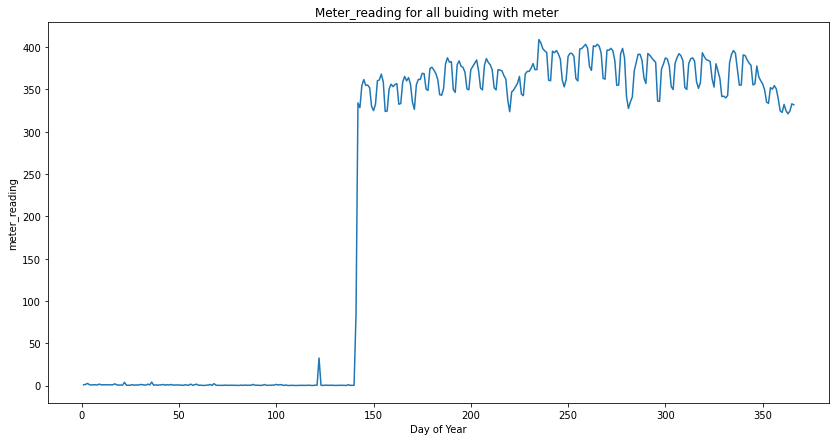

In [ ]:
df = train_data.query(f'meter=={0} and site_id=={0}')
df['day'] = pd.to_datetime(df['timestamp']).dt.dayofyear
d = df.groupby('day')['meter_reading'].mean()
plt.figure(figsize=(14,7))
plt.xlabel('Day of Year')
plt.ylabel('meter_reading')
plt.title('Meter_reading for all buiding with meter ')
plt.plot(d)

* For meter 0 and site_id 0 the building_id upto 104 meter_readings were zero for starting first 5 months and meter_readings have been taken started after 21st may. So, that zero reading datapoints must be removed. 

In [ ]:
train_data.drop(train_data[(train_data['building_id']<=104) & (train_data['meter']==0) & (train_data['timestamp']<'2016-05-21')].index,inplace=True)

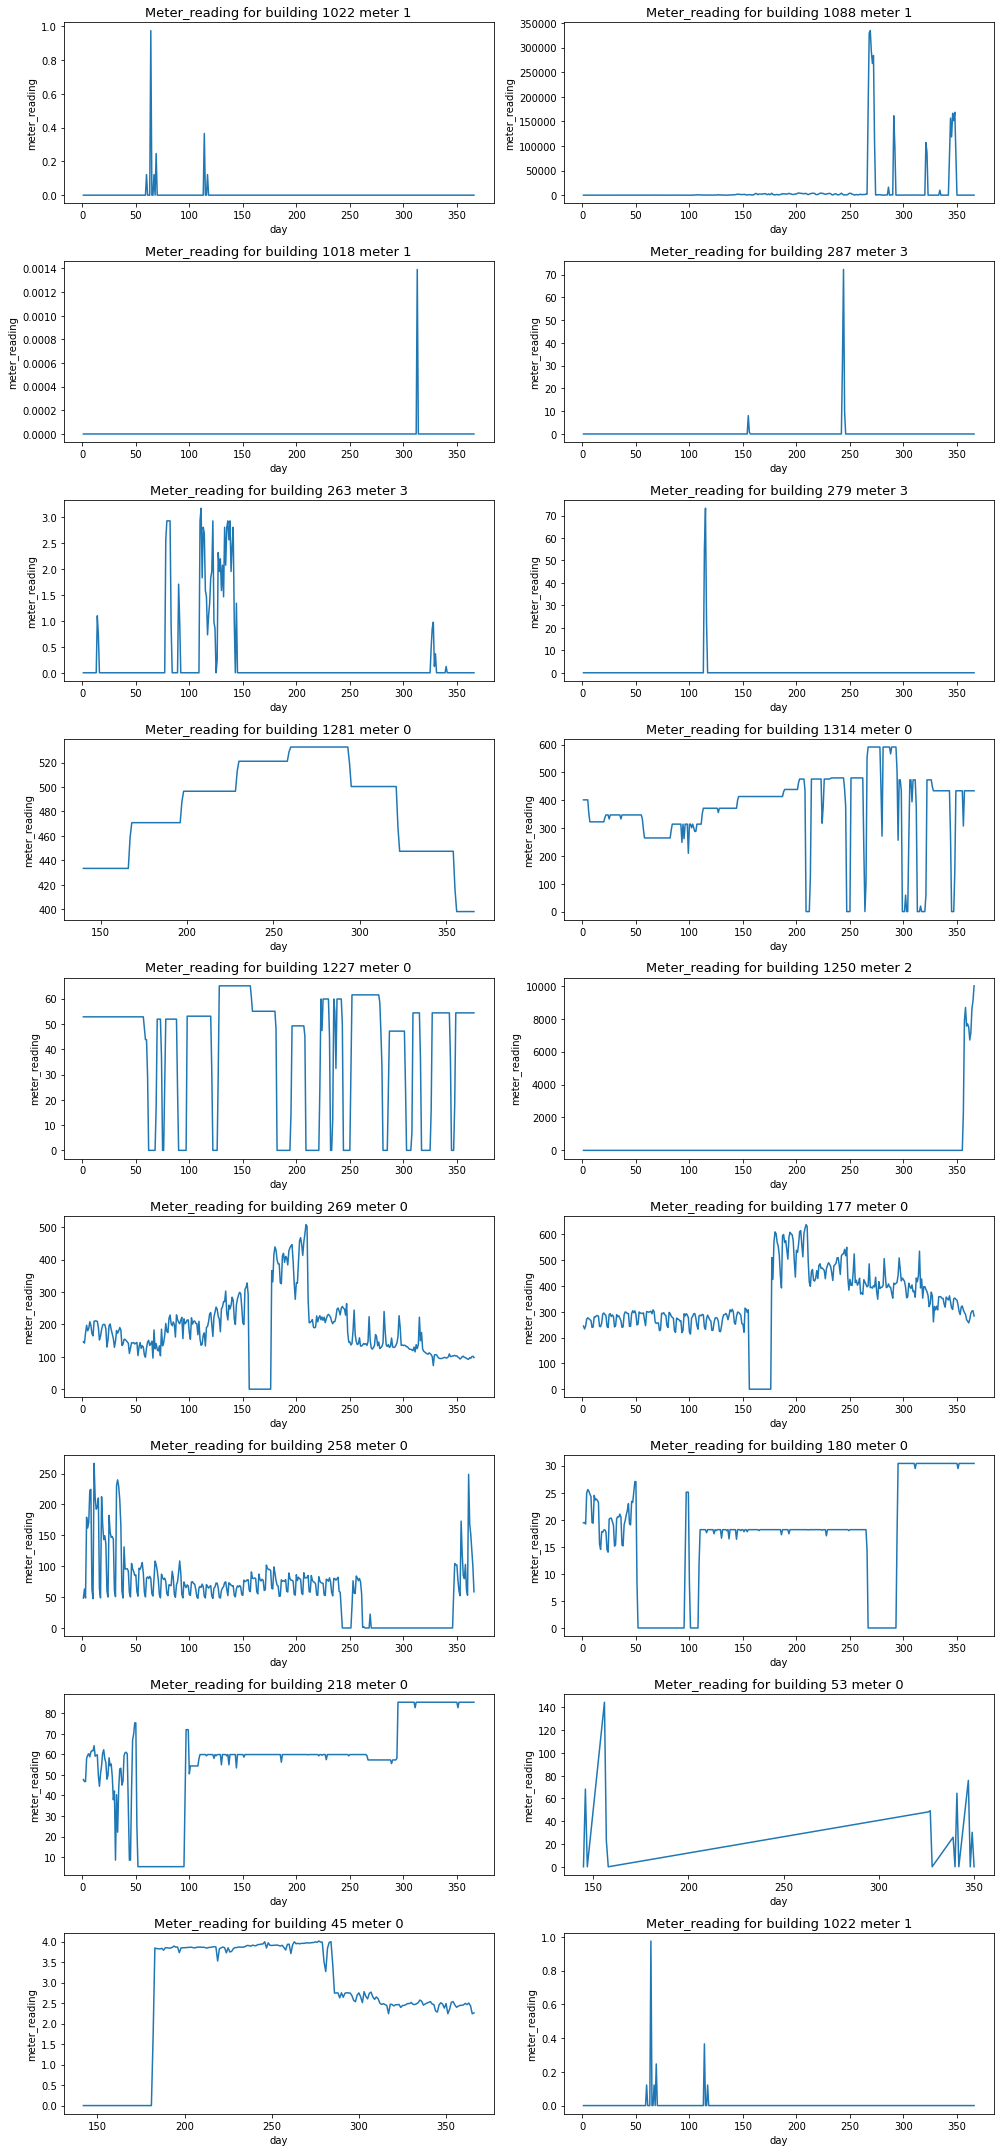

In [ ]:
dic = {45:0,53:0,103:0,218:0,180:0,258:0,177:0,269:0,1250:2,1227:0,1314:0,1281:0,279:3,263:3,287:3,1018:1,1088:1,1022:1}
fig, axes = plt.subplots(9,2,figsize=(14,30))
for row in range(9):
    for col in range(2):
        df = train_data.query(f'building_id=={list(dic.keys())[n]} and meter=={list(dic.values())[n]}')
        df['day'] = pd.to_datetime(df['timestamp']).dt.dayofyear
        d = df.groupby('day')['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('Meter_reading for building '+str(list(dic.keys())[n])+' meter '+str(list(dic.values())[n]), fontsize=13)
        axes[row,col].set_ylabel("meter_reading")
        plt.tight_layout()
        n = n+1


In [ ]:
dic = {45:0,53:0,218:0,180:0,258:0,177:0,269:0,1250:2,1227:0,1314:0,1281:0,279:3,263:3,287:3,1018:1,1088:1,1022:1}
for building_id,meter in dic.items():
    train_data.drop(train_data[(train_data['building_id']==building_id) & (train_data['meter']==meter)].index,inplace=True)

* Buildings with constant zero meter readings or showing high meter readings must be removed.

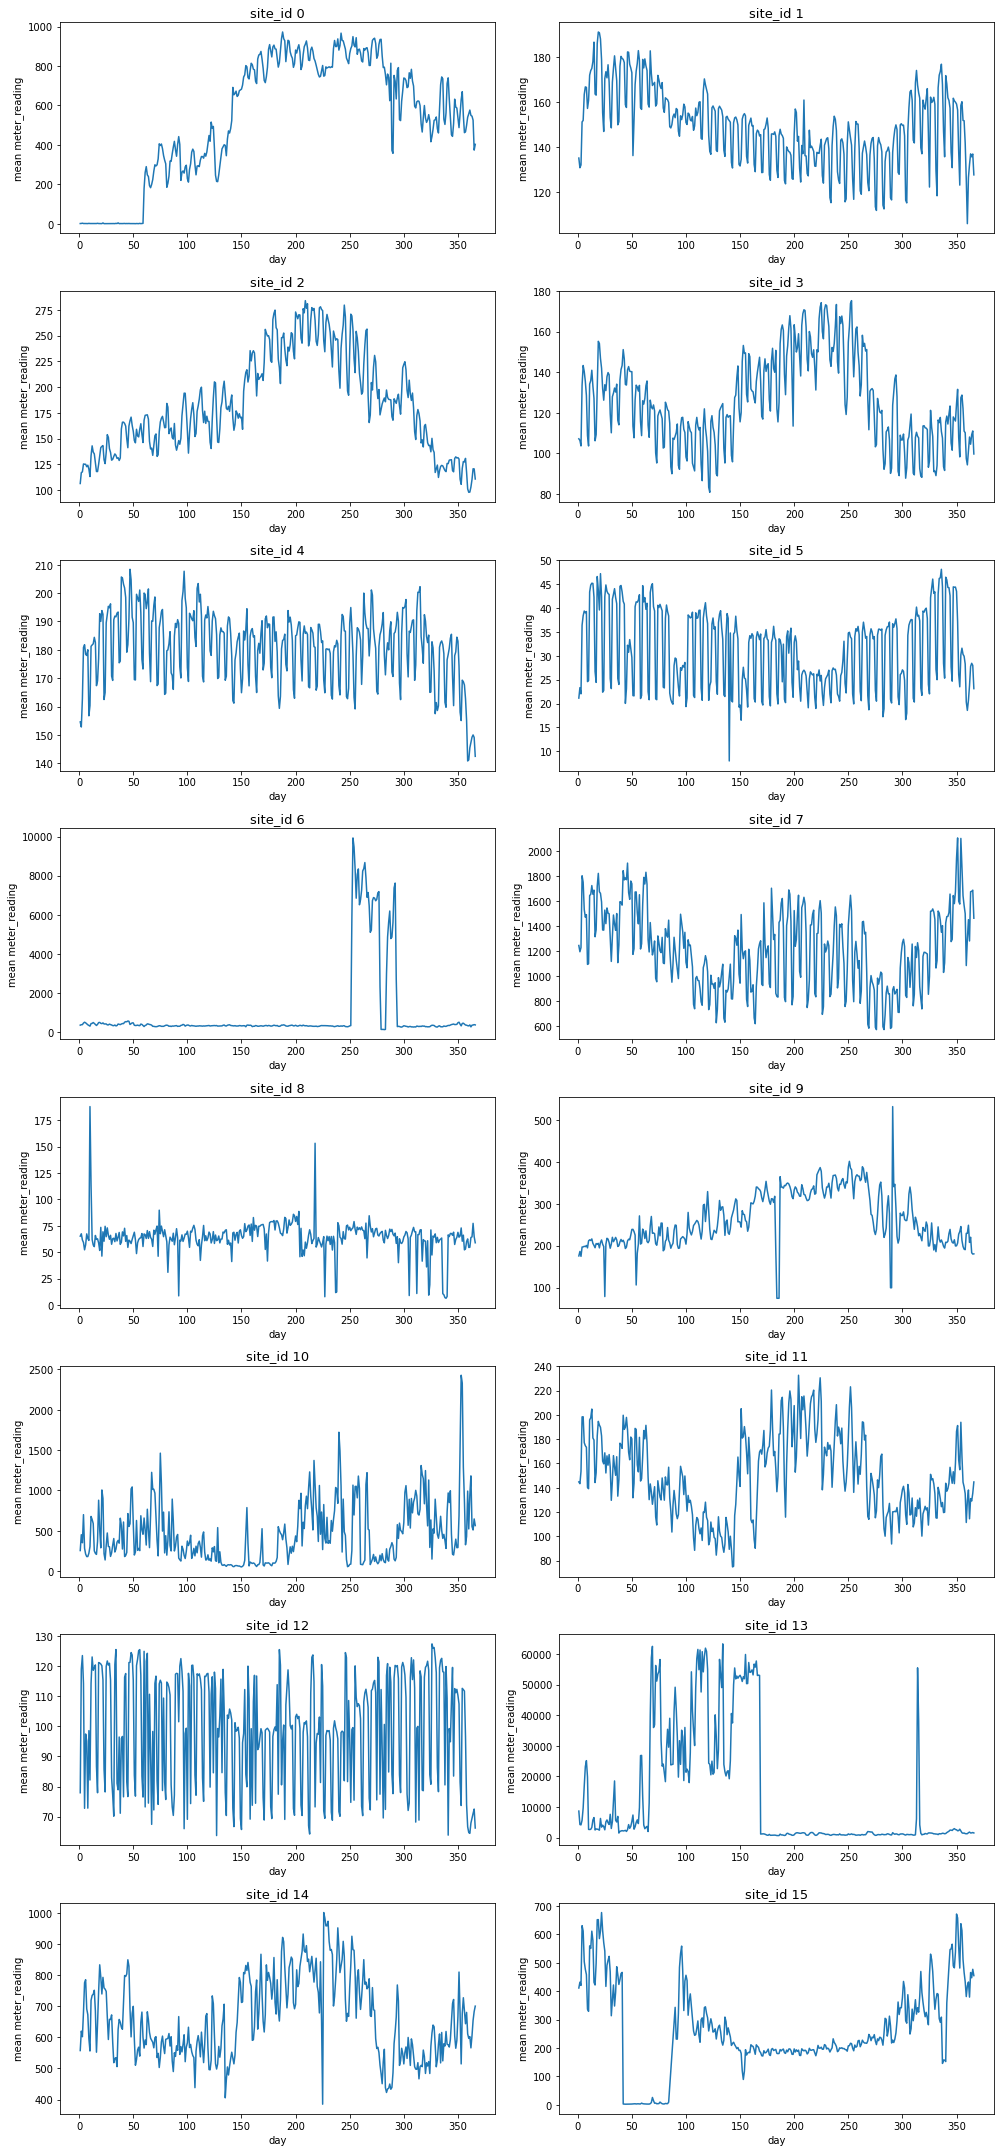

In [ ]:
#steam meter type plot for all buildings for meter_readings show some abnormal conditions. so,lets go deep by analysing for each site_id
n = 0
fig, axes = plt.subplots(8,2,figsize=(14,30))
for row in range(8):
    for col in range(2):
        d = train_data.query(f'site_id=={n}')
        d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
        d = d.groupby('day')['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('site_id {}'.format(n), fontsize=13)
        axes[row,col].set_ylabel("mean meter_reading")
        plt.tight_layout()
        n = n+1

        

* site_13 has similar plot as overall meter plot and from previous plots also we seen that site_13 is showing high meter readings.<br>
* we have to deep digger this site_13 based on primary_use

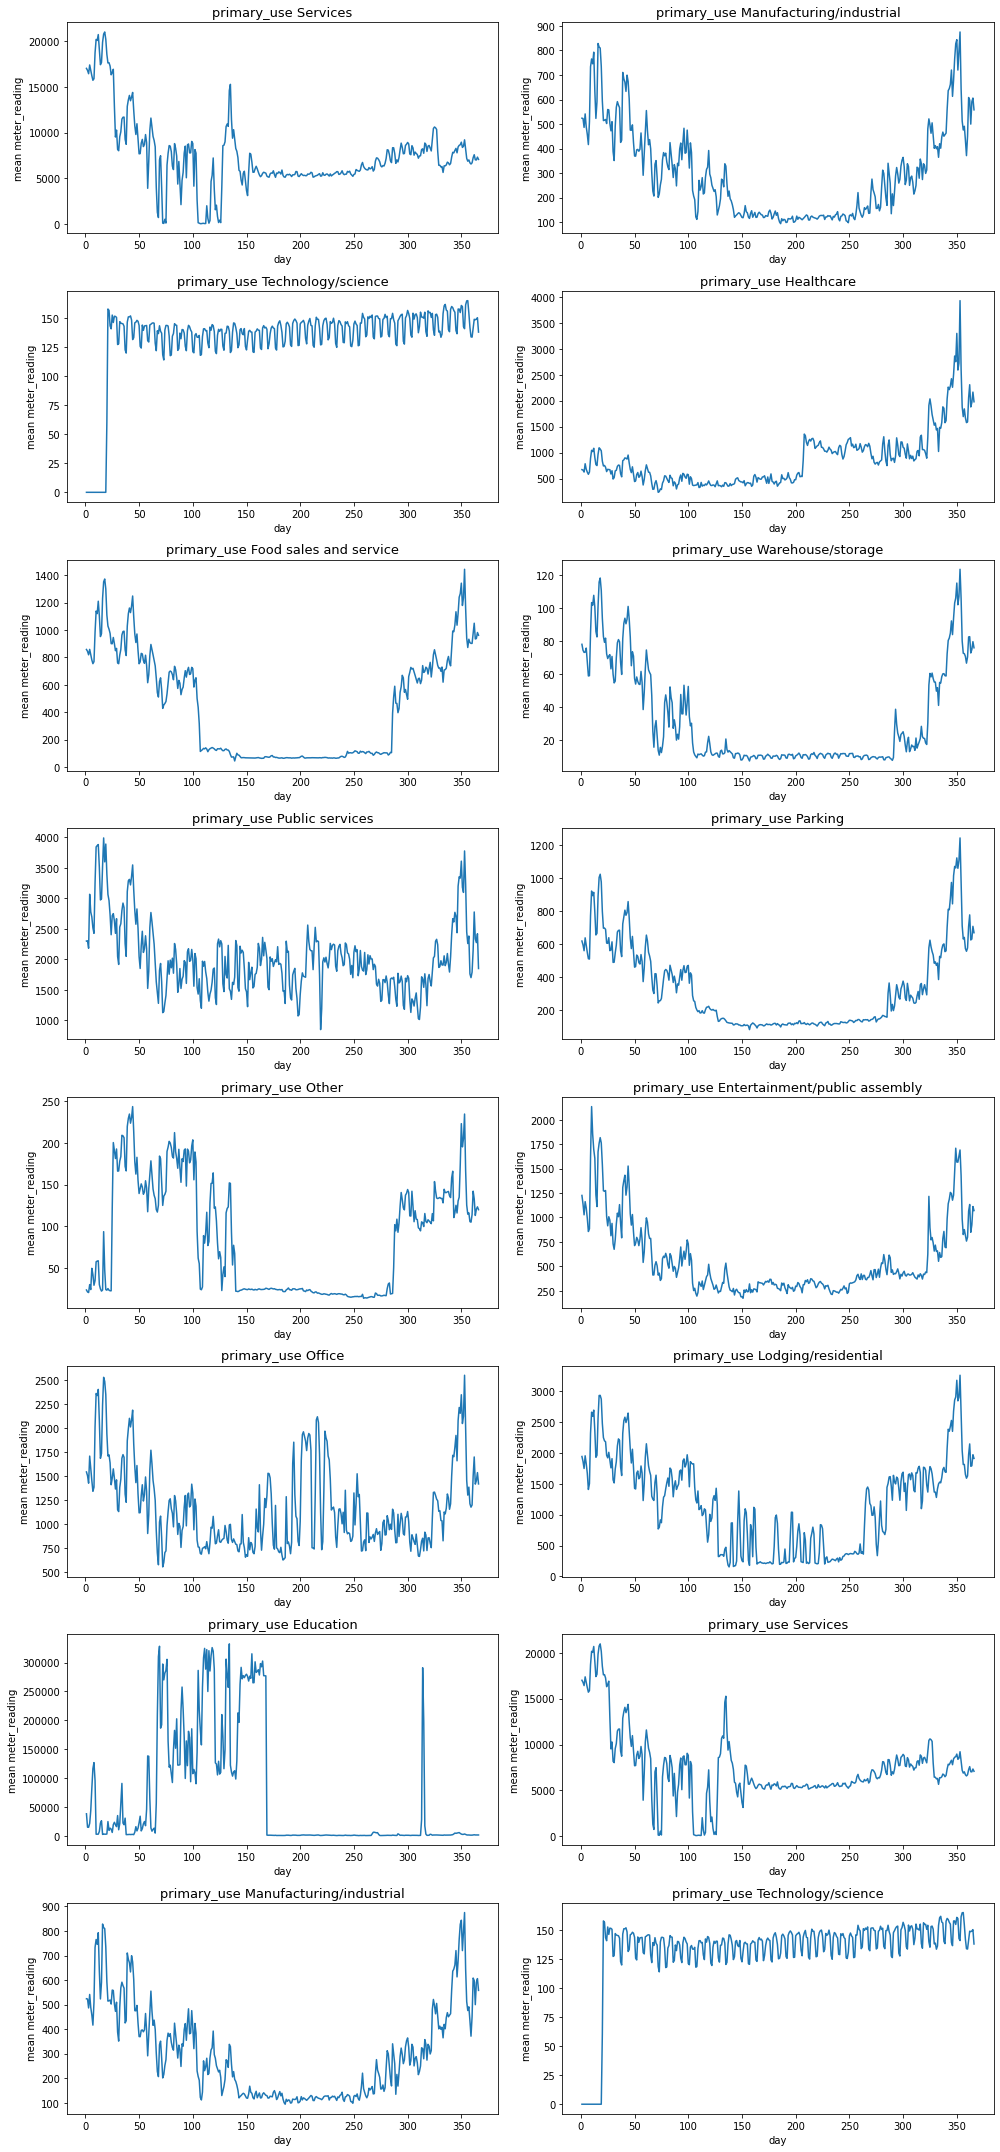

In [ ]:
n = 12
p_use=np.delete(train_data['primary_use'].unique(),[5,10,12])
fig, axes = plt.subplots(8,2,figsize=(14,30))
for row in range(8):
    for col in range(2):
        d = train_data.query(f"site_id=={13} and primary_use=='{p_use[n]}'")
        d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
        d = d.groupby(['day'])['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('primary_use {}'.format(p_use[n]), fontsize=13)
        axes[row,col].set_ylabel("mean meter_reading")
        plt.tight_layout()
        n = n-1



* Education building type looks similar with overall mean plot.<br>
* Now we need to find which building cause anomaly.

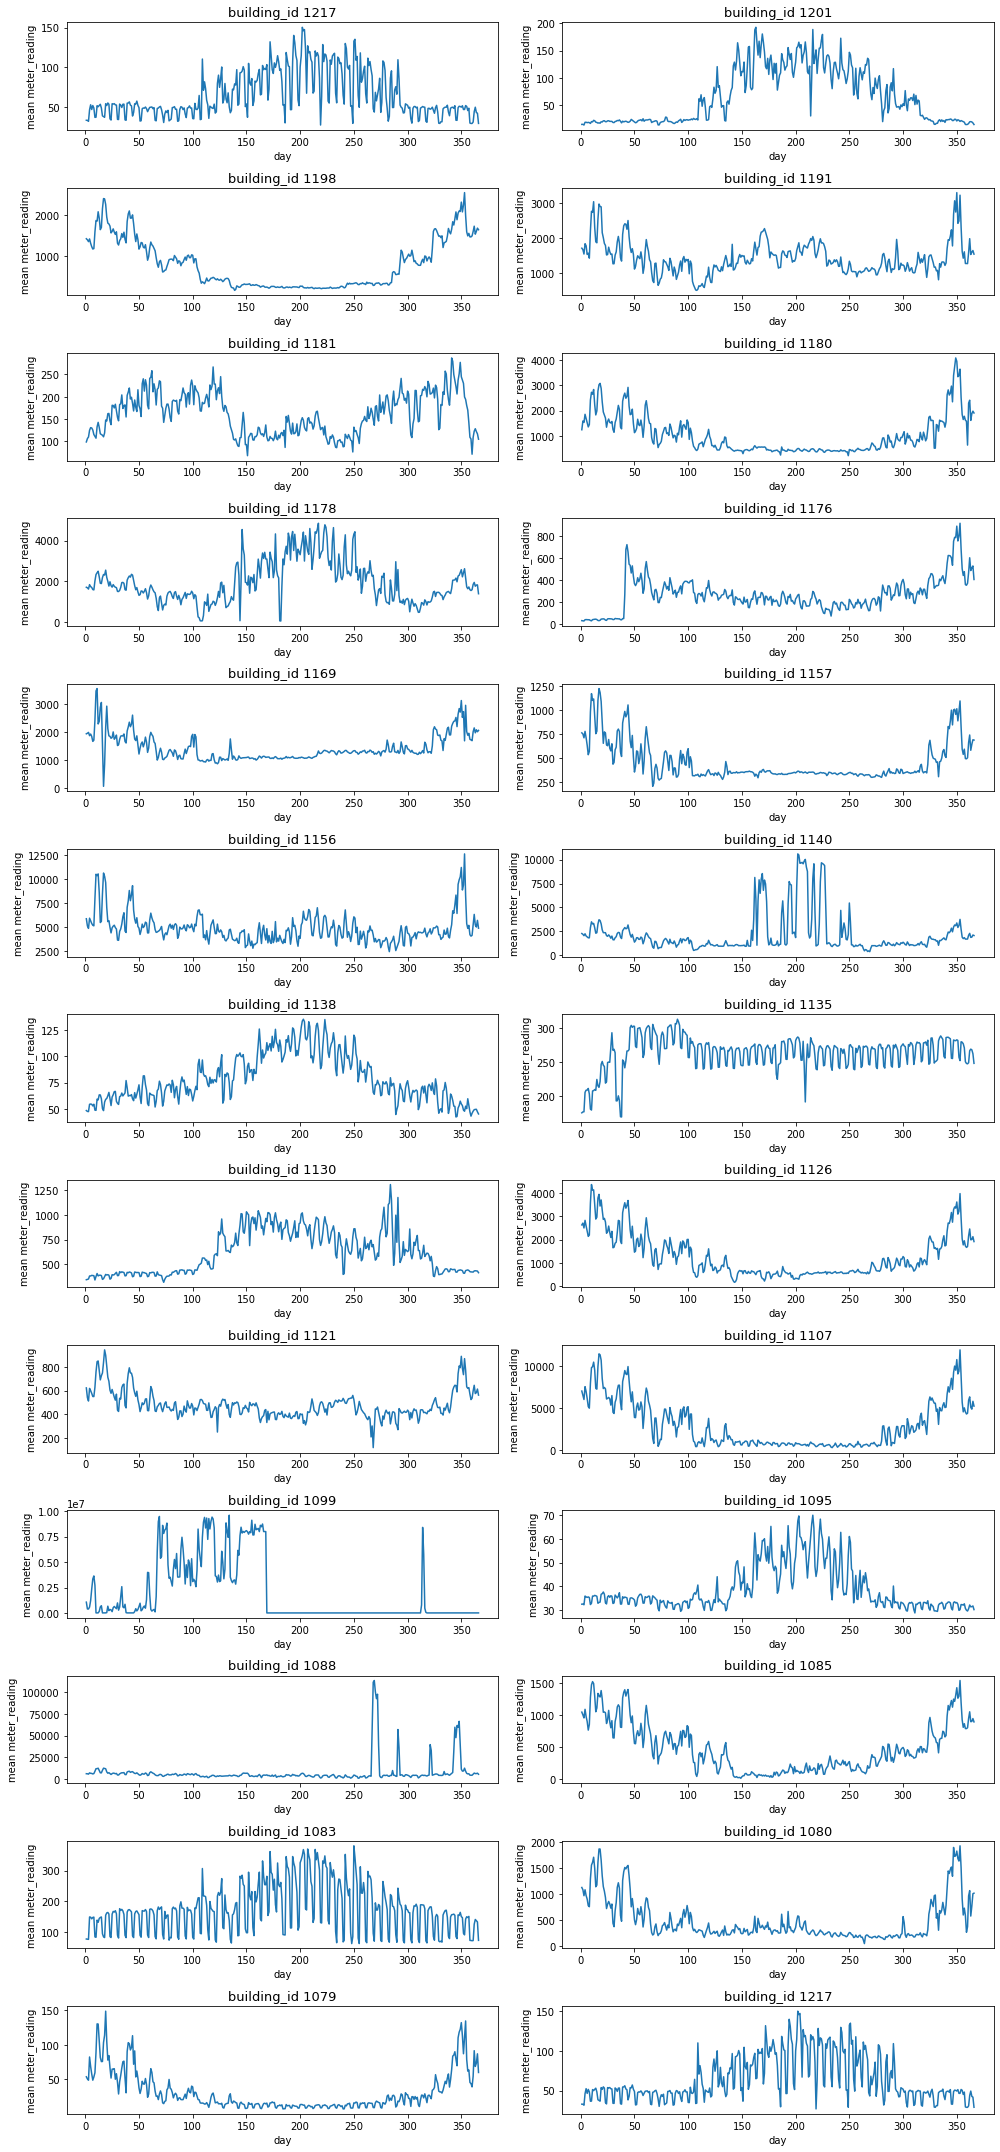

In [ ]:
n = 24
d = train_data.query(f"site_id=={13} and primary_use=='Education'")
building = d.building_id.unique()
fig, axes = plt.subplots(13,2,figsize=(14,30))
for row in range(13):
    for col in range(2):
        d = train_data.query(f"site_id=={13} and primary_use=='Education' and building_id=={building[n]}")
        d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
        d = d.groupby(['day'])['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('building_id {}'.format(building[n]), fontsize=13)
        axes[row,col].set_ylabel("mean meter_reading")
        plt.tight_layout()
        n = n-1
        

* building_id 1099 has plot similar to the overall meter reading mean plot. so it is outlier. we have to remove that building data.

In [ ]:
train_data.drop(train_data[(train_data['building_id'] ==1099)&(train_data['primary_use']=='Education')].index, inplace = True)

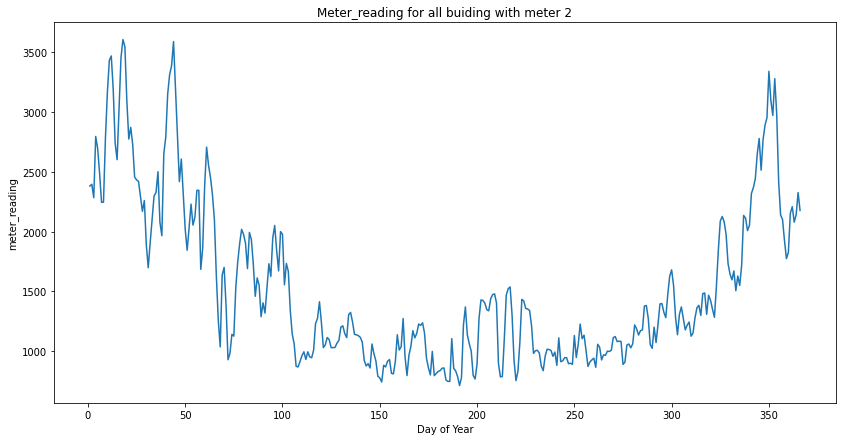

In [ ]:
meter = 2
df = train_data.query(f'meter=={meter}')
df['day'] = pd.to_datetime(df['timestamp']).dt.dayofyear
d = df.groupby('day')['meter_reading'].mean()
plt.figure(figsize=(14,7))
plt.xlabel('Day of Year')
plt.ylabel('meter_reading')
plt.title('Meter_reading for all buiding with meter '+str(meter))
plt.plot(d)

* This is plot after removing building_id 1099 data which was responsible for showing abnormal in the plot.<br>

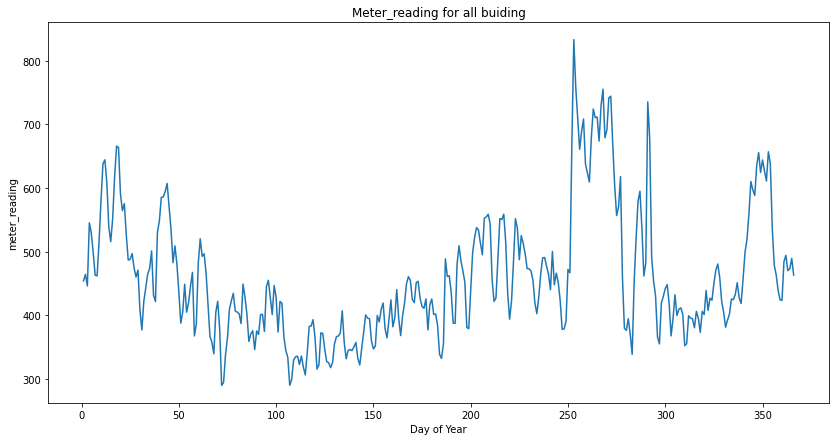

In [ ]:
d = train_data[['timestamp','meter_reading']]
d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
df = d.groupby('day')['meter_reading'].mean()
plt.figure(figsize=(14,7))
plt.xlabel('Day of Year')
plt.ylabel('meter_reading')
plt.title('Meter_reading for all buiding')
plt.plot(df)

* we see sudden increase september to till end of october.<br>
* from site_id plot we see that site_id 6 has second highest meter readings. so we have to digger the information of site_id 6.

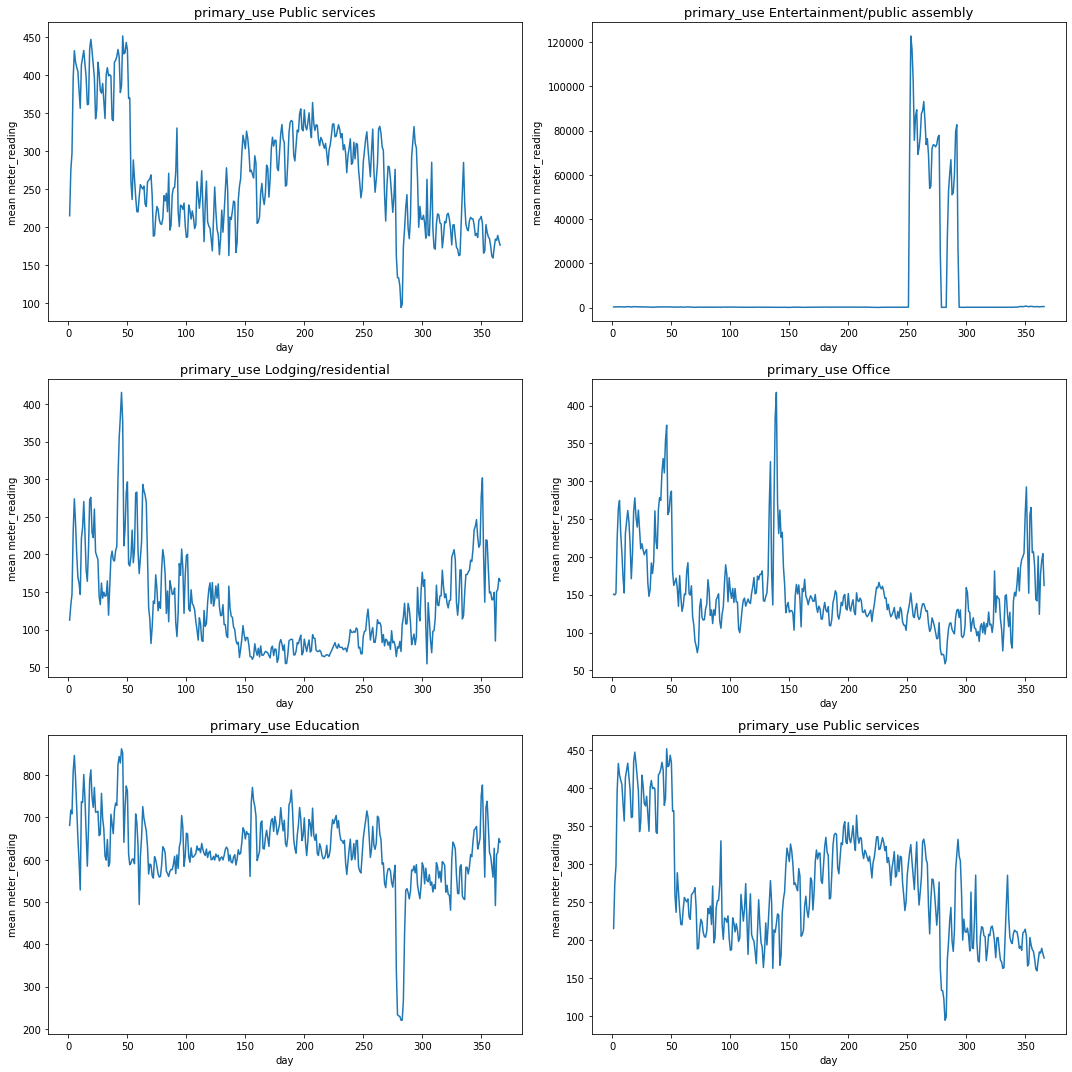

In [ ]:
df = train_data.query(f'site_id=={6}')
pri_n = df.primary_use.unique()
n = 4
fig, axes = plt.subplots(3,2,figsize=(15,15))
for row in range(3):
    for col in range(2):
        d = train_data.query(f"site_id=={6} and primary_use=='{pri_n[n]}'")
        d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
        d = d.groupby(['day'])['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('primary_use {}'.format(pri_n[n]), fontsize=13)
        axes[row,col].set_ylabel("mean meter_reading")
        plt.tight_layout()
        n = n-1


* From this we found abnormal behavior observed in Entertainment/public assembly building type.<br>
* Now we have to find the building.

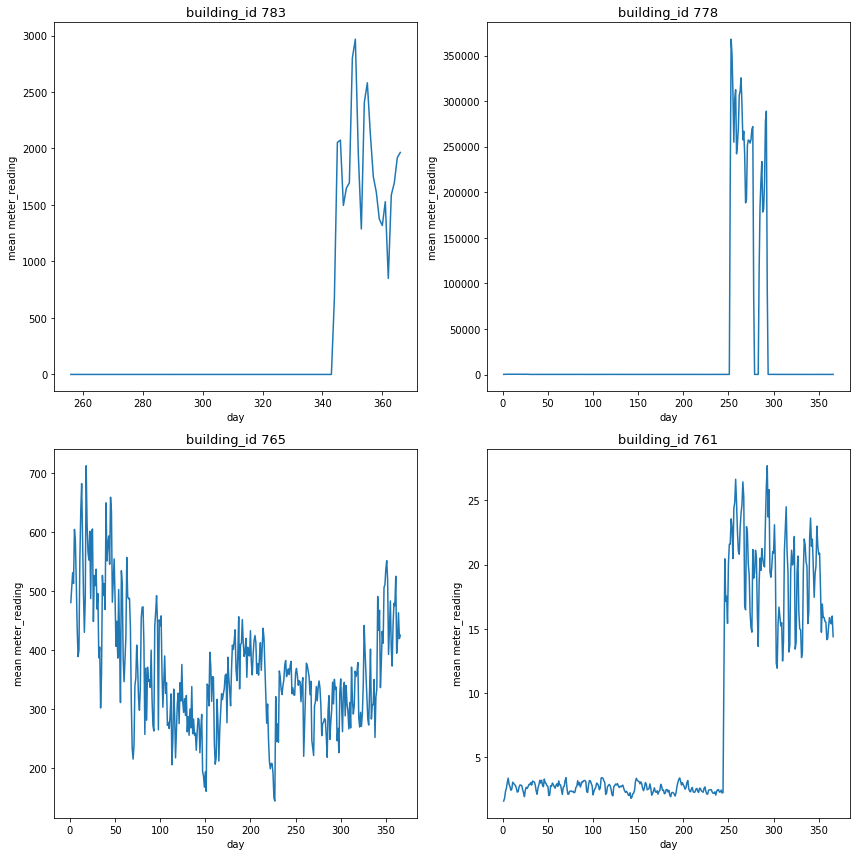

In [ ]:
df = train_data.query(f"site_id=={6} and primary_use=='Entertainment/public assembly'")
building = df.building_id.unique()
fig, axes = plt.subplots(2,2,figsize=(12,12))
n = 3
for row in range(2):
    for col in range(2):
        d = train_data.query(f"site_id=={6} and primary_use=='Entertainment/public assembly' and building_id=={building[n]}")
        d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
        d = d.groupby(['day'])['meter_reading'].mean()
        d.plot(ax=axes[row,col],alpha=1)
        axes[row,col].set_title('building_id {}'.format(building[n]), fontsize=13)
        axes[row,col].set_ylabel("mean meter_reading")
        plt.tight_layout()
        n = n-1

* we observe that building_id 778 looks similar to that of previous meter reading plot. so this building data dominating the overall plot.
<br>
* so we have to remove this building data. 

In [ ]:
train_data.drop(train_data[(train_data['building_id'] ==778)&(train_data['primary_use']=='Entertainment/public assembly')].index, inplace = True)

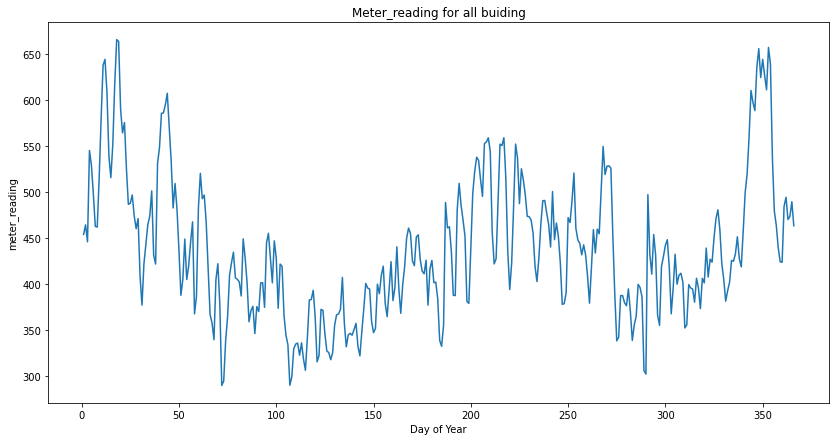

In [ ]:
d = train_data[['timestamp','meter_reading']]
d['day'] = pd.to_datetime(d['timestamp']).dt.dayofyear
df = d.groupby('day')['meter_reading'].mean()
plt.figure(figsize=(14,7))
plt.xlabel('Day of Year')
plt.ylabel('meter_reading')
plt.title('Meter_reading for all buiding')
plt.plot(df)

>Now we observe that plot looks good with reasonable readings.

#Dealing with Missing data


In [ ]:
features_with_na = [feature for feature in train_data.columns if train_data[feature].isnull().sum()>1]
for feature in features_with_na:
    print(feature+' : '+str(np.round(train_data[feature].isnull().mean(),4)))

year_built : 0.5999
floor_count : 0.8265
air_temperature : 0.0048
cloud_coverage : 0.4366
dew_temperature : 0.005
precip_depth_1_hr : 0.1854
sea_level_pressure : 0.0609
wind_direction : 0.0717
wind_speed : 0.0071


* Remove features which are having >80 of missing data. So, we remove floor_count feature.<br>
* For remaining missing values features we have to impute.

In [ ]:
#removing floor_count feature from data
train_data.drop('floor_count',axis=1,inplace=True)
train_data.reset_index(inplace=True)

In [ ]:
train_data['day'] = pd.to_datetime(train_data['timestamp']).dt.dayofyear
train_data['month'] = pd.to_datetime(train_data['timestamp']).dt.month

In [ ]:
train_data[['dew_temperature','cloud_coverage','year_built','air_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']] = train_data[['dew_temperature','cloud_coverage','year_built','air_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']].astype(np.float32)

In [ ]:
train_data = reduce_mem_usage(train_data)

Mem. usage decreased to 958.11 Mb (39.3% reduction)


In [ ]:
#filling nan values with interpolation method
train_data['air_temperature'] = train_data['air_temperature'].interpolate(method='linear').ffill().bfill()
train_data['dew_temperature'] = train_data['dew_temperature'].interpolate(method='linear').ffill().bfill()
train_data['cloud_coverage'] = train_data['cloud_coverage'].interpolate(method='linear').ffill().bfill()
train_data['wind_speed'] = train_data['wind_speed'].interpolate(method='linear').ffill().bfill()
train_data['wind_direction'] = train_data['wind_direction'].interpolate(method='linear').ffill().bfill()
train_data['sea_level_pressure'] = train_data['sea_level_pressure'].interpolate(method='linear').ffill().bfill()
train_data['precip_depth_1_hr'] = train_data['precip_depth_1_hr'].interpolate(method='linear').ffill().bfill()

In [ ]:
#for imputing year interpolation is not a good idea. so, by taking median grouping it by with site_id,month,day.
fill=train_data.groupby(['site_id','day','month'])['year_built'].median().reset_index()
fill.rename(columns={'year_built':'filler'},inplace=True)
fill['filler'].fillna(method='ffill',inplace=True)
train_data=train_data.merge(fill,how='left',on=['site_id','day','month'])
train_data['year_built'].fillna(train_data['filler'],inplace=True)
train_data.drop(labels=['filler'],axis=1,inplace=True)

In [ ]:
train_data = reduce_mem_usage(train_data)

Mem. usage decreased to 1108.41 Mb (21.3% reduction)


In [ ]:
train_data = train_data.reset_index()
train_data.to_feather('/content/drive/MyDrive/Ashrae_Great_Energy_Prediction/train_data_imputed.feather')